In [2]:
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

import warnings
import numpy as np
import pandas as pd

In [3]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

# Data Collecting

In [6]:
import yfinance as yf
CL=yf.download('CL=F',start = '2000-08-23')
HO=yf.download('HO=F',start = '2000-09-01')
NG=yf.download('NG=F',start = '2000-08-30')
RB=yf.download('RB=F',start = '2000-11-01')
BZ=yf.download('BZ=F',start = '2007-07-30')
ZL=yf.download('ZL=F',start = '2000-03-15')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Data Preprocessing

In [11]:
CL['return'] = CL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
HO['return'] = HO['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
NG['return'] = NG['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
RB['return'] = RB['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
BZ['return'] = BZ['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))
ZL['return'] = ZL['Adj Close'].pct_change().apply(lambda x: np.log(1 + x))

In [12]:
CL_vol = CL['return'].rolling(window=5).std()
HO_vol = HO['return'].rolling(window=5).std()
NG_vol = NG['return'].rolling(window=5).std()
RB_vol = RB['return'].rolling(window=5).std()
BZ_vol = BZ['return'].rolling(window=5).std()
ZL_vol = ZL['return'].rolling(window=5).std()

In [14]:
CL_vol.to_csv('Database/oil_std/CL_vol.csv')
HO_vol.to_csv('Database/oil_std/HO_vol.csv')
NG_vol.to_csv('Database/oil_std/NG_vol.csv')
RB_vol.to_csv('Database/oil_std/RB_vol.csv')
BZ_vol.to_csv('Database/oil_std/BZ_vol.csv')
ZL_vol.to_csv('Database/oil_std/ZL_vol.csv')

# General preprocessing

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Forecasting')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Volatility')

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30'),
  Text(35.0, 0, '35')])

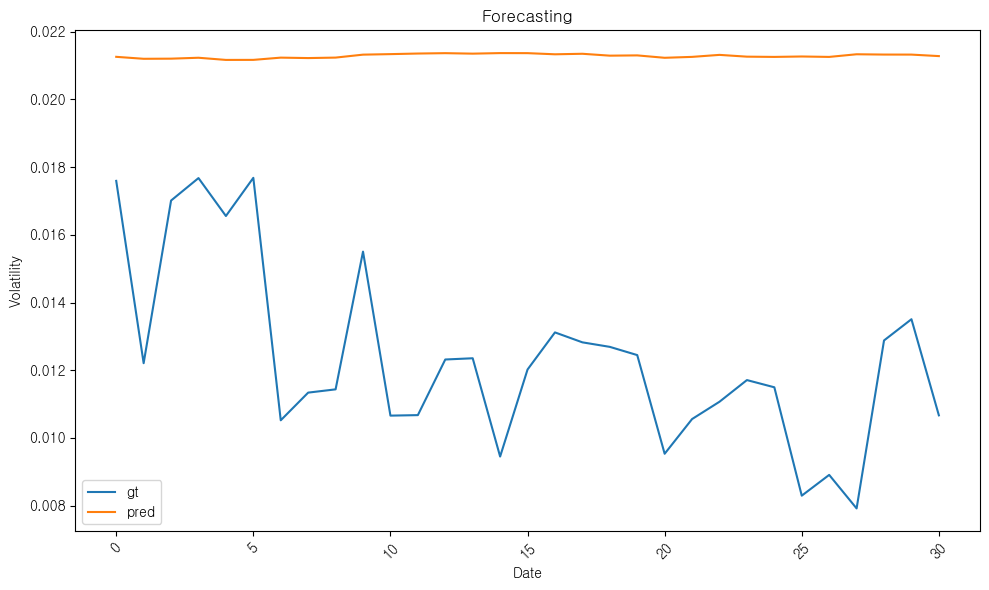

In [99]:
pred = pd.read_csv('Files/bi_LSTM_bno.csv')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.plot(pred['Ground Truths'], label='gt')
plt.plot(pred['Predictions'], label='pred')


plt.title(f'Forecasting')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Save Files

In [95]:
# wti_vol.to_csv('Database/oil_std/wti_vol.csv')
# bno_vol.to_csv('Database/oil_std/bno_vol.csv')